# Imports, Installations, Config

### Install

In [ ]:
!pip install torch==1.8.1+cu111 torchvision==0.9.1+cu111 torchaudio==0.8.1 -f https://download.pytorch.org/whl/lts/1.8/torch_lts.html
!pip install torchtext==0.9.1
!pip install segmentation_models_pytorch

Looking in links: https://download.pytorch.org/whl/lts/1.8/torch_lts.html
     |█████████████▌                  | 834.1 MB 1.3 MB/s eta 0:14:54tcmalloc: large alloc 1147494400 bytes == 0x55f398e82000 @  0x7fc88ef5d615 0x55f35eb5802c 0x55f35ec3817a 0x55f35eb5ae4d 0x55f35ec4cc0d 0x55f35ebcf0d8 0x55f35ebc9c35 0x55f35eb5c73a 0x55f35ebcef40 0x55f35ebc9c35 0x55f35eb5c73a 0x55f35ebcb93b 0x55f35ec4da56 0x55f35ebcafb3 0x55f35ec4da56 0x55f35ebcafb3 0x55f35ec4da56 0x55f35ebcafb3 0x55f35eb5cb99 0x55f35eb9fe79 0x55f35eb5b7b2 0x55f35ebcee65 0x55f35ebc9c35 0x55f35eb5c73a 0x55f35ebcb93b 0x55f35ebc9c35 0x55f35eb5c73a 0x55f35ebcab0e 0x55f35eb5c65a 0x55f35ebcad67 0x55f35ebc9c35
     |█████████████████               | 1055.7 MB 1.3 MB/s eta 0:12:09tcmalloc: large alloc 1434370048 bytes == 0x55f3dd4d8000 @  0x7fc88ef5d615 0x55f35eb5802c 0x55f35ec3817a 0x55f35eb5ae4d 0x55f35ec4cc0d 0x55f35ebcf0d8 0x55f35ebc9c35 0x55f35eb5c73a 0x55f35ebcef40 0x55f35ebc9c35 0x55f35eb5c73a 0x55f35ebcb93b 0x55f35ec4da56 0x55f35

### Imports

In [ ]:
import os
import glob
from PIL import Image
import cv2
import matplotlib.image as mpimg
from matplotlib import pyplot as plt

from tqdm import tqdm
from typing import Optional, List
import numpy as np
import pandas as pd
import math

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.nn.modules.loss import _Loss
from torch.utils.data.dataset import Dataset
import albumentations as A
import segmentation_models_pytorch as smp

### Loss

In [ ]:
# LOSS
__all__ = [
    "focal_loss_with_logits",
    "softmax_focal_loss_with_logits",
    "soft_jaccard_score",
    "soft_dice_score",
    "wing_loss",
]


def to_tensor(x, dtype=None) -> torch.Tensor:
    if isinstance(x, torch.Tensor):
        if dtype is not None:
            x = x.type(dtype)
        return x
    if isinstance(x, np.ndarray):
        x = torch.from_numpy(x)
        if dtype is not None:
            x = x.type(dtype)
        return x
    if isinstance(x, (list, tuple)):
        x = np.ndarray(x)
        x = torch.from_numpy(x)
        if dtype is not None:
            x = x.type(dtype)
        return x


def focal_loss_with_logits(
    output: torch.Tensor,
    target: torch.Tensor,
    gamma: float = 2.0,
    alpha: Optional[float] = 0.25,
    reduction: str = "mean",
    normalized: bool = False,
    reduced_threshold: Optional[float] = None,
    eps: float = 1e-6,
) -> torch.Tensor:
    """Compute binary focal loss between target and output logits.
    See :class:`~pytorch_toolbelt.losses.FocalLoss` for details.
    Args:
        output: Tensor of arbitrary shape (predictions of the model)
        target: Tensor of the same shape as input
        gamma: Focal loss power factor
        alpha: Weight factor to balance positive and negative samples. Alpha must be in [0...1] range,
            high values will give more weight to positive class.
        reduction (string, optional): Specifies the reduction to apply to the output:
            'none' | 'mean' | 'sum' | 'batchwise_mean'. 'none': no reduction will be applied,
            'mean': the sum of the output will be divided by the number of
            elements in the output, 'sum': the output will be summed. Note: :attr:`size_average`
            and :attr:`reduce` are in the process of being deprecated, and in the meantime,
            specifying either of those two args will override :attr:`reduction`.
            'batchwise_mean' computes mean loss per sample in batch. Default: 'mean'
        normalized (bool): Compute normalized focal loss (https://arxiv.org/pdf/1909.07829.pdf).
        reduced_threshold (float, optional): Compute reduced focal loss (https://arxiv.org/abs/1903.01347).
    References:
        https://github.com/open-mmlab/mmdetection/blob/master/mmdet/core/loss/losses.py
    """
    target = target.type(output.type())

    logpt = F.binary_cross_entropy_with_logits(output, target, reduction="none")
    pt = torch.exp(-logpt)

    # compute the loss
    if reduced_threshold is None:
        focal_term = (1.0 - pt).pow(gamma)
    else:
        focal_term = ((1.0 - pt) / reduced_threshold).pow(gamma)
        focal_term[pt < reduced_threshold] = 1

    loss = focal_term * logpt

    if alpha is not None:
        loss *= alpha * target + (1 - alpha) * (1 - target)

    if normalized:
        norm_factor = focal_term.sum().clamp_min(eps)
        loss /= norm_factor

    if reduction == "mean":
        loss = loss.mean()
    if reduction == "sum":
        loss = loss.sum()
    if reduction == "batchwise_mean":
        loss = loss.sum(0)

    return loss


def softmax_focal_loss_with_logits(
    output: torch.Tensor,
    target: torch.Tensor,
    gamma: float = 2.0,
    reduction="mean",
    normalized=False,
    reduced_threshold: Optional[float] = None,
    eps: float = 1e-6,
) -> torch.Tensor:
    """Softmax version of focal loss between target and output logits.
    See :class:`~pytorch_toolbelt.losses.FocalLoss` for details.
    Args:
        output: Tensor of shape [B, C, *] (Similar to nn.CrossEntropyLoss)
        target: Tensor of shape [B, *] (Similar to nn.CrossEntropyLoss)
        reduction (string, optional): Specifies the reduction to apply to the output:
            'none' | 'mean' | 'sum' | 'batchwise_mean'. 'none': no reduction will be applied,
            'mean': the sum of the output will be divided by the number of
            elements in the output, 'sum': the output will be summed. Note: :attr:`size_average`
            and :attr:`reduce` are in the process of being deprecated, and in the meantime,
            specifying either of those two args will override :attr:`reduction`.
            'batchwise_mean' computes mean loss per sample in batch. Default: 'mean'
        normalized (bool): Compute normalized focal loss (https://arxiv.org/pdf/1909.07829.pdf).
        reduced_threshold (float, optional): Compute reduced focal loss (https://arxiv.org/abs/1903.01347).
    """
    log_softmax = F.log_softmax(output, dim=1)

    loss = F.nll_loss(log_softmax, target, reduction="none")
    pt = torch.exp(-loss)

    # compute the loss
    if reduced_threshold is None:
        focal_term = (1.0 - pt).pow(gamma)
    else:
        focal_term = ((1.0 - pt) / reduced_threshold).pow(gamma)
        focal_term[pt < reduced_threshold] = 1

    loss = focal_term * loss

    if normalized:
        norm_factor = focal_term.sum().clamp_min(eps)
        loss = loss / norm_factor

    if reduction == "mean":
        loss = loss.mean()
    if reduction == "sum":
        loss = loss.sum()
    if reduction == "batchwise_mean":
        loss = loss.sum(0)

    return loss


def soft_jaccard_score(
    output: torch.Tensor, target: torch.Tensor, smooth: float = 0.0, eps: float = 1e-7, dims=None
) -> torch.Tensor:
    assert output.size() == target.size()
    if dims is not None:
        intersection = torch.sum(output * target, dim=dims)
        cardinality = torch.sum(output + target, dim=dims)
    else:
        intersection = torch.sum(output * target)
        cardinality = torch.sum(output + target)

    union = cardinality - intersection
    jaccard_score = (intersection + smooth) / (union + smooth).clamp_min(eps)
    return jaccard_score


def soft_dice_score(
    output: torch.Tensor, target: torch.Tensor, smooth: float = 0.0, eps: float = 1e-7, dims=None
) -> torch.Tensor:
    assert output.size() == target.size()
    if dims is not None:
        intersection = torch.sum(output * target, dim=dims)
        cardinality = torch.sum(output + target, dim=dims)
    else:
        intersection = torch.sum(output * target)
        cardinality = torch.sum(output + target)
    dice_score = (2.0 * intersection + smooth) / (cardinality + smooth).clamp_min(eps)
    return dice_score


def wing_loss(output: torch.Tensor, target: torch.Tensor, width=5, curvature=0.5, reduction="mean"):
    """
    https://arxiv.org/pdf/1711.06753.pdf
    :param output:
    :param target:
    :param width:
    :param curvature:
    :param reduction:
    :return:
    """
    diff_abs = (target - output).abs()
    loss = diff_abs.clone()

    idx_smaller = diff_abs < width
    idx_bigger = diff_abs >= width

    loss[idx_smaller] = width * torch.log(1 + diff_abs[idx_smaller] / curvature)

    C = width - width * math.log(1 + width / curvature)
    loss[idx_bigger] = loss[idx_bigger] - C

    if reduction == "sum":
        loss = loss.sum()

    if reduction == "mean":
        loss = loss.mean()

    return loss


def label_smoothed_nll_loss(
    lprobs: torch.Tensor, target: torch.Tensor, epsilon: float, ignore_index=None, reduction="mean", dim=-1
) -> torch.Tensor:
    """
    Source: https://github.com/pytorch/fairseq/blob/master/fairseq/criterions/label_smoothed_cross_entropy.py
    :param lprobs: Log-probabilities of predictions (e.g after log_softmax)
    :param target:
    :param epsilon:
    :param ignore_index:
    :param reduction:
    :return:
    """
    if target.dim() == lprobs.dim() - 1:
        target = target.unsqueeze(dim)

    if ignore_index is not None:
        pad_mask = target.eq(ignore_index)
        target = target.masked_fill(pad_mask, 0)
        nll_loss = -lprobs.gather(dim=dim, index=target)
        smooth_loss = -lprobs.sum(dim=dim, keepdim=True)

        # nll_loss.masked_fill_(pad_mask, 0.0)
        # smooth_loss.masked_fill_(pad_mask, 0.0)
        nll_loss = nll_loss.masked_fill(pad_mask, 0.0)
        smooth_loss = smooth_loss.masked_fill(pad_mask, 0.0)
    else:
        nll_loss = -lprobs.gather(dim=dim, index=target)
        smooth_loss = -lprobs.sum(dim=dim, keepdim=True)

        nll_loss = nll_loss.squeeze(dim)
        smooth_loss = smooth_loss.squeeze(dim)

    if reduction == "sum":
        nll_loss = nll_loss.sum()
        smooth_loss = smooth_loss.sum()
    if reduction == "mean":
        nll_loss = nll_loss.mean()
        smooth_loss = smooth_loss.mean()

    eps_i = epsilon / lprobs.size(dim)
    loss = (1.0 - epsilon) * nll_loss + eps_i * smooth_loss
    return loss


BINARY_MODE: str = "binary"
MULTICLASS_MODE: str = "multiclass"
MULTILABEL_MODE: str = "multilabel"

__all__ = ["DiceLoss"]


class DiceLoss(_Loss):

    def __init__(
        self,
        mode: str,
        classes: Optional[List[int]] = None,
        log_loss: bool = False,
        from_logits: bool = True,
        smooth: float = 0.0,
        ignore_index: Optional[int] = None,
        eps: float = 1e-7,
    ):
        """Implementation of Dice loss for image segmentation task.
        It supports binary, multiclass and multilabel cases
        Args:
            mode: Loss mode 'binary', 'multiclass' or 'multilabel'
            classes:  List of classes that contribute in loss computation. By default, all channels are included.
            log_loss: If True, loss computed as `- log(dice_coeff)`, otherwise `1 - dice_coeff`
            from_logits: If True, assumes input is raw logits
            smooth: Smoothness constant for dice coefficient (a)
            ignore_index: Label that indicates ignored pixels (does not contribute to loss)
            eps: A small epsilon for numerical stability to avoid zero division error 
                (denominator will be always greater or equal to eps)
        Shape
             - **y_pred** - torch.Tensor of shape (N, C, H, W)
             - **y_true** - torch.Tensor of shape (N, H, W) or (N, C, H, W)
        Reference
            https://github.com/BloodAxe/pytorch-toolbelt
        """
        assert mode in {BINARY_MODE, MULTILABEL_MODE, MULTICLASS_MODE}
        super(DiceLoss, self).__init__()
        self.mode = mode
        if classes is not None:
            assert mode != BINARY_MODE, "Masking classes is not supported with mode=binary"
            classes = to_tensor(classes, dtype=torch.long)

        self.classes = classes
        self.from_logits = from_logits
        self.smooth = smooth
        self.eps = eps
        self.log_loss = log_loss
        self.ignore_index = ignore_index

    def forward(self, y_pred: torch.Tensor, y_true: torch.Tensor) -> torch.Tensor:

        assert y_true.size(0) == y_pred.size(0)

        if self.from_logits:
            # Apply activations to get [0..1] class probabilities
            # Using Log-Exp as this gives more numerically stable result and does not cause vanishing gradient on
            # extreme values 0 and 1
            if self.mode == MULTICLASS_MODE:
                y_pred = y_pred.log_softmax(dim=1).exp()
            else:
                y_pred = F.logsigmoid(y_pred).exp()

        bs = y_true.size(0)
        num_classes = y_pred.size(1)
        dims = (0, 2)

        if self.mode == BINARY_MODE:
            y_true = y_true.view(bs, 1, -1)
            y_pred = y_pred.view(bs, 1, -1)

            if self.ignore_index is not None:
                mask = y_true != self.ignore_index
                y_pred = y_pred * mask
                y_true = y_true * mask

        if self.mode == MULTICLASS_MODE:
            y_true = y_true.view(bs, -1)
            y_pred = y_pred.view(bs, num_classes, -1)

            if self.ignore_index is not None:
                mask = y_true != self.ignore_index
                y_pred = y_pred * mask.unsqueeze(1)

                y_true = F.one_hot((y_true * mask).to(torch.long), num_classes)  # N,H*W -> N,H*W, C
                y_true = y_true.permute(0, 2, 1) * mask.unsqueeze(1)  # H, C, H*W
            else:
                y_true = F.one_hot(y_true, num_classes)  # N,H*W -> N,H*W, C
                y_true = y_true.permute(0, 2, 1)  # H, C, H*W

        if self.mode == MULTILABEL_MODE:
            y_true = y_true.view(bs, num_classes, -1)
            y_pred = y_pred.view(bs, num_classes, -1)

            if self.ignore_index is not None:
                mask = y_true != self.ignore_index
                y_pred = y_pred * mask
                y_true = y_true * mask

        scores = soft_dice_score(y_pred, y_true.type_as(y_pred), smooth=self.smooth, eps=self.eps, dims=dims)

        if self.log_loss:
            loss = -torch.log(scores.clamp_min(self.eps))
        else:
            loss = 1.0 - scores

        # Dice loss is undefined for non-empty classes
        # So we zero contribution of channel that does not have true pixels
        # NOTE: A better workaround would be to use loss term `mean(y_pred)`
        # for this case, however it will be a modified jaccard loss

        mask = y_true.sum(dims) > 0
        loss *= mask.to(loss.dtype)

        if self.classes is not None:
            loss = loss[self.classes]

        return loss.mean()


loss = DiceLoss('multiclass')
loss.__name__='Dice_loss'
metrics=[]

### Dataset Class

In [ ]:
# Subclass and define custom dataset ===========================
class MultiClassSegDataset(Dataset):
    
    def __init__(self, df, classes=None, transform=None,):
        self.df = df
        self.classes = classes
        self.transform = transform
    
    def __getitem__(self, idx):
        
        image_name = self.df.iloc[idx, 2]
        mask_name = self.df.iloc[idx, 3]
        #print('this is the img name',image_name)
        image = cv2.imread(image_name)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_name, cv2.IMREAD_UNCHANGED)
        image = image.astype('uint8')
        mask = mask[:,:,0]
        if(self.transform is not None):
            transformed = self.transform(image=image, mask=mask)
            image = transformed["image"]
            mask = transformed["mask"]
            image = torch.from_numpy(image)
            mask = torch.from_numpy(mask)   
            image = image.permute(2, 0, 1)
            image = image.float()/255
            mask = mask.long().unsqueeze(0)
        else: 
            image = torch.from_numpy(image)
            mask = torch.from_numpy(mask)
            image = image.permute(2, 0, 1)
            image = image.float()/255
            mask = mask.long().unsqueeze(0)
        return image, mask  
        
    def __len__(self):
        return len(self.df)

### Mount Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
os.getcwd()

Mounted at /content/drive


'/content'

#Load one image

In [ ]:
path='/content/drive/MyDrive/LCC/GID/1_Full_Dimension/IMG/GF2_PMS2__L1A0001768200-MSS2.tif'

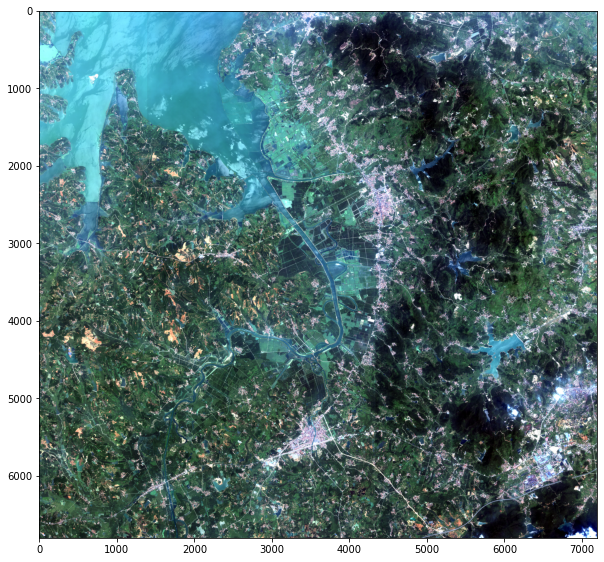

In [ ]:
img = Image.open(path)
plt.figure(figsize=(10,10))
plt.imshow(img)
plt.show()

#First Stage

### Downsample

In [ ]:
def downscaler(img_path, output_path,fraction=2):
  owd = os.getcwd()
  img_name = os.path.splitext(os.path.basename(img_path))[0]
  img = mpimg.imread(img_path)
  dim = (int(img.shape[1]/fraction), int(img.shape[0]/fraction))
  os.chdir(output_path)
  cv2.imwrite(f"{img_name.rsplit('.',1)[0]}_downscaled.png",cv2.resize(cv2.cvtColor(img,cv2.COLOR_RGB2BGR), dim, interpolation = cv2.INTER_NEAREST))
  os.chdir(owd)
  pass

In [ ]:
os.mkdir('1st_stage_downscaled')

In [ ]:
input=path
output='1st_stage_downscaled'
downscaler(input, output)

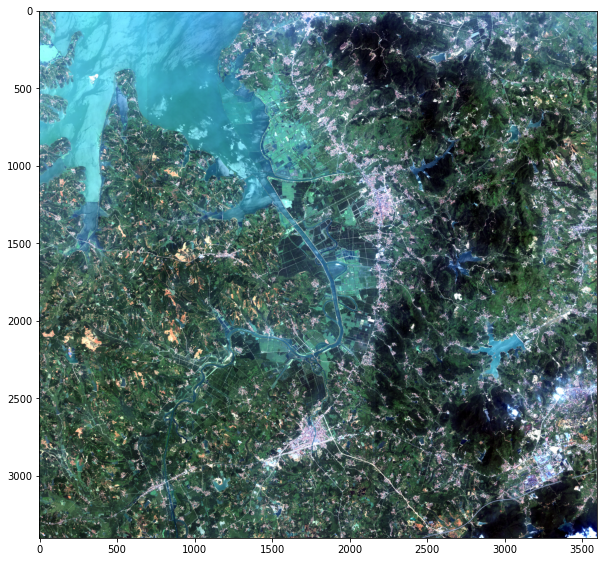

In [ ]:
downscaled_path='/content/1st_stage_downscaled/GF2_PMS2__L1A0001768200-MSS2_downscaled.png'
img = Image.open(downscaled_path)
plt.figure(figsize=(10,10))
plt.imshow(img)
plt.show()

### Split for first stage

In [ ]:
os.getcwd()
os.mkdir('1st_stage_cropped')
os.mkdir('1st_stage_cropped/IMG')

In [ ]:
img_filename = os.path.splitext(os.path.basename(path))[0]
   
img = cv2.imread(downscaled_path)

TARGET_SIZE=512
OUTPUT_IMG_DIR='1st_stage_cropped/IMG'

k = 0
for y in range(0, img.shape[0], TARGET_SIZE):
    for x in range(0, img.shape[1], TARGET_SIZE):
        img_tile = img[y:y + TARGET_SIZE, x:x + TARGET_SIZE]

        if img_tile.shape[0] == TARGET_SIZE and img_tile.shape[1] == TARGET_SIZE:
            out_img_path = os.path.join(OUTPUT_IMG_DIR, "{}_{}.png".format(img_filename, k))
            cv2.imwrite(out_img_path, img_tile)

        k += 1

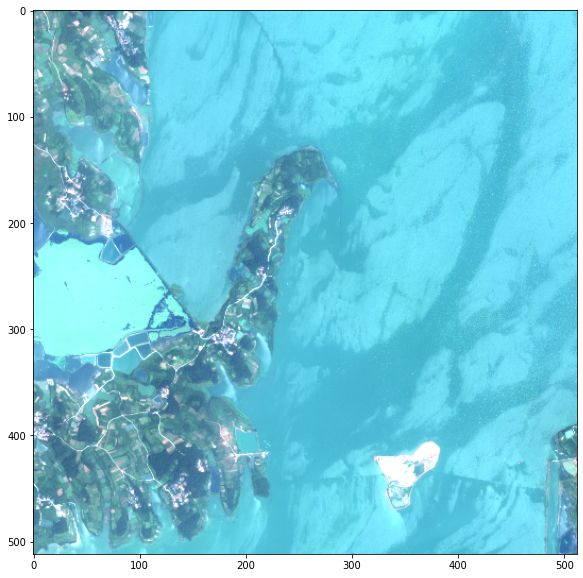

In [ ]:
cropped_path = '/content/1st_stage_cropped/IMG/GF2_PMS2__L1A0001768200-MSS2_0.png'
img = Image.open(cropped_path)
plt.figure(figsize=(10,10))
plt.imshow(img)
plt.show()

### Load and Apply first stage model

In [ ]:
#PARAMETERS
MULTICLASS_MODE: str = "multiclass"
ENCODER = "resnet18"
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ['background', 'built-up', 'farmland', 'forest','meadow','water']
ACTIVATION = None
DEVICE = 'cuda'

#MODEL
model = smp.DeepLabV3Plus(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    in_channels=3,
    classes=6,
    activation=ACTIVATION,
)
optimizer = optim.Adam(params=model.parameters(), lr=0.001)

#LOADING TRAINED MODEL
checkpoint = torch.load('drive/MyDrive/LCC/model_gid.pth')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epochs = checkpoint['epoch']
criterion = checkpoint['loss']

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


### Predictions

In [ ]:
def img_processing(folder,name):
  image = cv2.imread(folder + name)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = image.astype('uint8')
  image = np.expand_dims(image, axis=0)
  image = torch.from_numpy(image)
  image = image.permute(0, 3, 1, 2)
  image = image.float()/255
  return image
  #image = image.to(torch.device('cuda'))

In [ ]:
def prediction_results(model, in_path, numpy_results, mask_results):
  folder = in_path
  cropped_images = os.listdir(in_path)
  cropped_images_list=os.listdir(cropped_path)
  cropped_images_list=sorted(cropped_images_list, key=lambda cropped_images_list: int(cropped_images_list.replace('.','_').split('_')[-2]))
  m = nn.Softmax(dim=1)
  for img_name in cropped_images_list:
    processed_img = img_processing(folder,img_name)
    pred_tensor = model.predict(processed_img)
    numpy_results.append(pred_tensor.numpy().squeeze())
    pr_probs = m(pred_tensor)   
    pr_mask = torch.argmax(pred_tensor, dim=1).squeeze(1) 
    pr_mask = (pr_mask.squeeze().cpu().numpy().round())
    mask_results.append(pr_mask)

In [ ]:
#Predictiong the masks for first stage
cropped_path = '/content/1st_stage_cropped/IMG/'
cropped_path_MSK = '/content/1st_stage_cropped/MSK/'
in_path  = cropped_path
out_path = cropped_path_MSK
cropped_images = os.listdir(in_path)
cropped_images_list=os.listdir(cropped_path)
cropped_images_list=sorted(cropped_images_list, key=lambda cropped_images_list: int(cropped_images_list.replace('.','_').split('_')[-2]))
numpy_results=[]
mask_results=[]
prediction_results(model, in_path, numpy_results, mask_results)

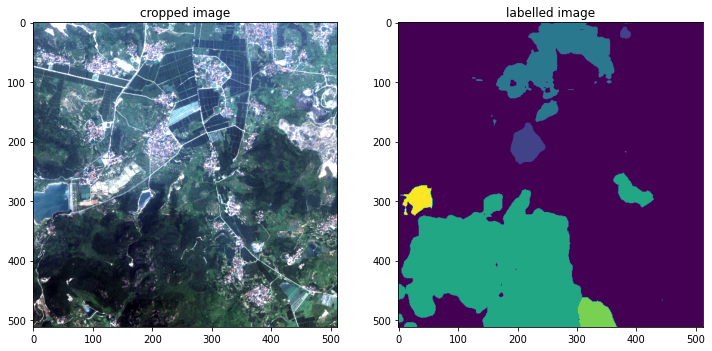

In [ ]:
#plot exemple of the result for single patch of the first stage patches
img_num=5

fig,a =  plt.subplots(1,2)
import numpy as np
x = np.arange(1,5)
a[0].imshow(Image.open(in_path+cropped_images_list[img_num]))
a[0].set_title('cropped image')
a[1].imshow(mask_results[img_num])
a[1].set_title('labelled image')
fig.set_figheight(12)
fig.set_figwidth(12)
plt.show()

### Merge Images 

In [ ]:
# MERGING FUNCTIONS
def imgs2row(mask_results, number_of_cols):
  # initialize matrix 
  merged_matrix = mask_results[0]
  #build raw 
  for col in range(number_of_cols-1):
    merged_matrix = np.concatenate((merged_matrix,mask_results[col+1]),axis=1)
  return merged_matrix
def merge_masks(mask_results, number_of_cols, number_of_rows):
  # initialize first row
  merged_matrix=imgs2row(mask_results,number_of_cols)
  for row in range(number_of_rows-1):
    merged_matrix = np.concatenate((merged_matrix,imgs2row(mask_results[(row+1)*number_of_cols:], number_of_cols)),axis=0)
  return merged_matrix
def MergeNumpyRows(numpy_results, number_of_cols):
  # initialize matrix 
  merged_matrix = numpy_results[0]
  #build raw 
  for col in range(number_of_cols-1):
    merged_matrix = np.concatenate((merged_matrix,numpy_results[col+1]),axis=2)
  return merged_matrix
def MergeNumpyMatrixes(numpy_results, number_of_cols, number_of_rows):
  # initialize first row
  merged_matrix = MergeNumpyRows(numpy_results,number_of_cols)
  for row in range(number_of_rows-1):
    merged_matrix = np.concatenate((merged_matrix,MergeNumpyRows(numpy_results[(row+1)*number_of_cols:], number_of_cols)),axis=1)
  return merged_matrix

In [ ]:
number_of_cols = 7 #14
number_of_rows = 6 #13
mm=merge_masks(mask_results, number_of_cols, number_of_rows)
print('Dimensions predicted masks: ',mm.shape)
ma=MergeNumpyMatrixes(numpy_results, number_of_cols, number_of_rows)
print('Dimensions predicted morfology probabilities: ',ma.shape)

Dimensions predicted masks:  (3072, 3584)
Dimensions predicted morfology probabilities:  (6, 3072, 3584)


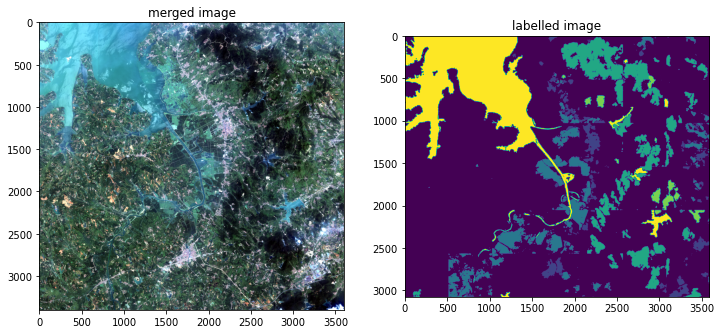

In [ ]:
# PRINTING DOWNSCALED IMAGE AND MERGED PREDICTION
fig,a =  plt.subplots(1,2)
import numpy as np
x = np.arange(1,5)
a[0].imshow(Image.open(downscaled_path))
a[0].set_title('merged image')
a[1].imshow(mm)
a[1].set_title('labelled image')
fig.set_figheight(12)
fig.set_figwidth(12)
plt.show()

### Upsample

In [ ]:
from skimage.transform import resize

print('shape of the prediction: ',mm.shape)
print('shape of the prediction probabilities array: ',ma.shape)
new_size = [2*x for x in mm.shape]
classes=[ma.shape[0]]
upsampled_mm = resize(mm, tuple(new_size), order = 0,preserve_range=True)
upsampled_ma = resize(ma, tuple(classes+new_size), order = 0,preserve_range=True)

print('shape of the upsampled prediction: ',upsampled_mm.shape)
print('shape of the upsampled prediction probabilities array: ',upsampled_mm.shape)

shape of the prediction:  (3072, 3584)
shape of the prediction probabilities array:  (6, 3072, 3584)
shape of the upsampled prediction:  (6144, 7168)
shape of the upsampled prediction probabilities array:  (6144, 7168)


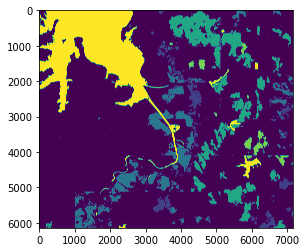

In [ ]:
plt.imshow(upsampled_mm)

#Second Stage

###Split for second stage

In [ ]:
os.getcwd()
os.mkdir('2nd_stage_cropped')
os.mkdir('2nd_stage_cropped/IMG')

In [ ]:
img_filename = os.path.splitext(os.path.basename(path))[0]
   
img = cv2.imread(path)

TARGET_SIZE=512
OUTPUT_IMG_DIR='2nd_stage_cropped/IMG'

k = 0
for y in range(0, img.shape[0], TARGET_SIZE):
    for x in range(0, img.shape[1], TARGET_SIZE):
        img_tile = img[y:y + TARGET_SIZE, x:x + TARGET_SIZE]

        if img_tile.shape[0] == TARGET_SIZE and img_tile.shape[1] == TARGET_SIZE:
            out_img_path = os.path.join(OUTPUT_IMG_DIR, "{}_{}.png".format(img_filename, k))
            cv2.imwrite(out_img_path, img_tile)

        k += 1

###Load and Apply first stage model

In [ ]:
#PARAMETERS
MULTICLASS_MODE: str = "multiclass"
ENCODER = "resnet18"
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ['background', 'built-up', 'farmland', 'forest','meadow','water']
ACTIVATION = None
DEVICE = 'cuda'

#MODEL
model2 = smp.DeepLabV3Plus(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    in_channels=3,
    classes=6,
    activation=ACTIVATION,
)
optimizer = optim.Adam(params=model.parameters(), lr=0.001)

#LOADING TRAINED MODEL
checkpoint = torch.load('drive/MyDrive/LCC/model_gid_2nd_layer.pth')
model2.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epochs = checkpoint['epoch']
criterion = checkpoint['loss']

In [ ]:
#Predictiong the masks for second stage
cropped_path = '/content/2nd_stage_cropped/IMG/'
cropped_path_MSK = '/content/2nd_stage_cropped/MSK/'
in_path  = cropped_path
out_path = cropped_path_MSK
cropped_images = os.listdir(in_path)
cropped_images_list=os.listdir(cropped_path)
cropped_images_list=sorted(cropped_images_list, key=lambda cropped_images_list: int(cropped_images_list.replace('.','_').split('_')[-2]))
numpy_results_2=[]
mask_results_2=[]
prediction_results(model2, in_path, numpy_results_2, mask_results_2)

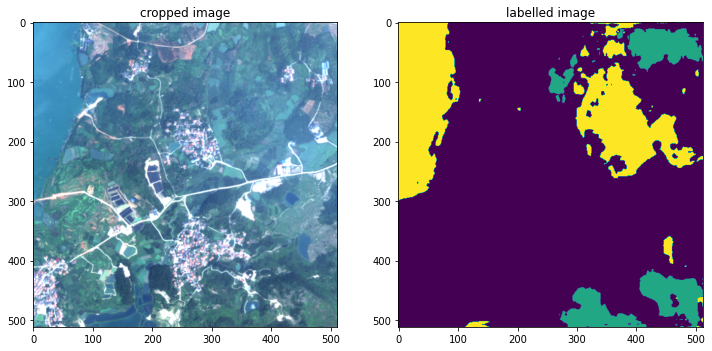

In [ ]:
#plot exemple of the result for second stage patches
img_num=5

fig,a =  plt.subplots(1,2)
import numpy as np
x = np.arange(1,5)
a[0].imshow(Image.open(in_path+cropped_images_list[img_num]))
a[0].set_title('cropped image')
a[1].imshow(mask_results_2[img_num])
a[1].set_title('labelled image')
fig.set_figheight(12)
fig.set_figwidth(12)
plt.show()

### Merge Images

In [ ]:
number_of_cols = 14
number_of_rows = 13
mm_2=merge_masks(mask_results_2, number_of_cols, number_of_rows)
print('Dimensions predicted masks: ',mm_2.shape)
ma_2=MergeNumpyMatrixes(numpy_results_2, number_of_cols, number_of_rows)
print('Dimensions predicted morfology probabilities: ',ma_2.shape)

Dimensions predicted masks:  (6656, 7168)
Dimensions predicted morfology probabilities:  (6, 6656, 7168)


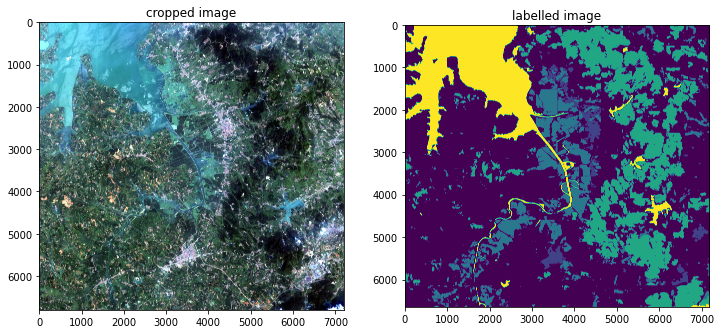

In [ ]:
# PRINTING DOWNSCALED IMAGE AND MERGED PREDICTION
fig,a =  plt.subplots(1,2)
import numpy as np
x = np.arange(1,5)
a[0].imshow(Image.open(path))
a[0].set_title('cropped image')
a[1].imshow(mm_2)
a[1].set_title('labelled image')
fig.set_figheight(12)
fig.set_figwidth(12)
plt.show()

# Fusion Block

In [ ]:
fusion_matrix=upsampled_ma+ma_2[:,:6144,:]
#fusion_matrix

In [ ]:
fusion_tensor = torch.from_numpy(fusion_matrix)
print(fusion_tensor.unsqueeze(0).shape)
fusion_mask = torch.argmax(fusion_tensor, dim=0).squeeze(1) 
fusion_mask = (fusion_mask.squeeze().cpu().numpy().round())
print(fusion_mask.shape)

torch.Size([1, 6, 6144, 7168])
(6144, 7168)


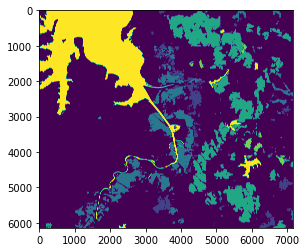

In [ ]:
plt.imshow(fusion_mask)

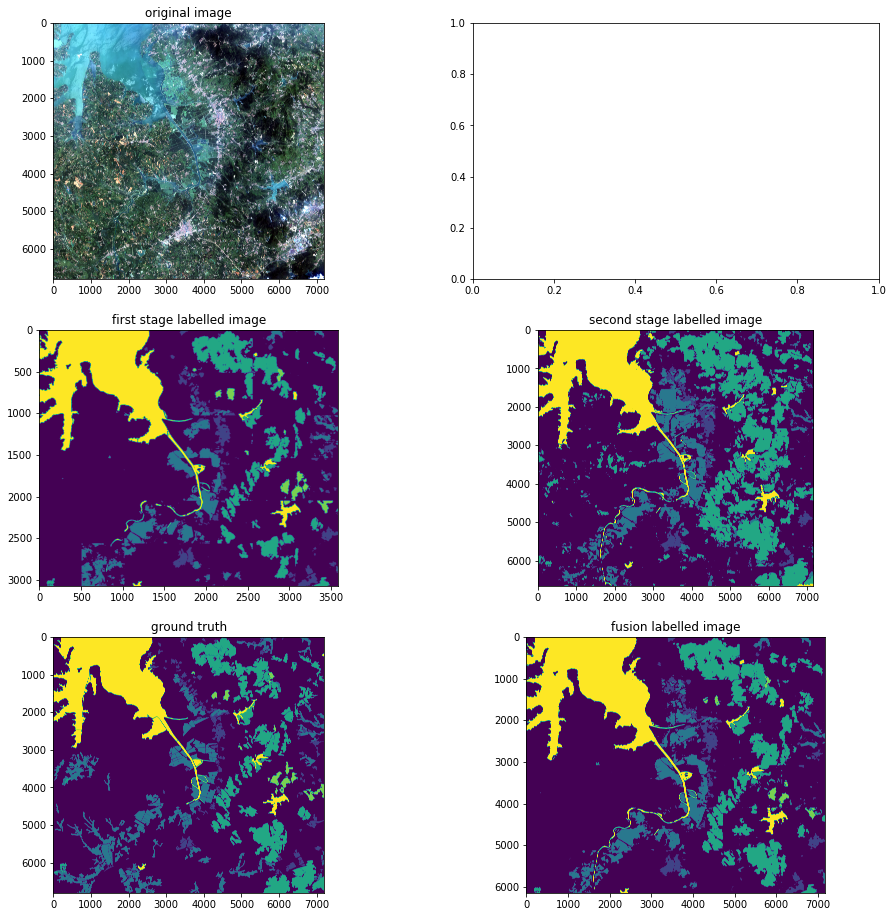

In [ ]:
fig,a =  plt.subplots(3,2)
import numpy as np
original = Image.open(path)
a[0][0].imshow(original)
a[0][0].set_title('original image')
a[1][0].imshow(mm)
a[1][0].set_title('first stage labelled image')
a[1][1].imshow(mm_2)
a[1][1].set_title('second stage labelled image')

ground_truth='/content/drive/MyDrive/LCC/GID/1_Full_Dimension/MSK_1ch/GF2_PMS2__L1A0001768200-MSS2.tif'
import numpy as np
ground_truth = Image.open(ground_truth)
a[2][0].imshow(ground_truth)
a[2][0].set_title('ground truth')
a[2][1].imshow(fusion_mask)
a[2][1].set_title('fusion labelled image')

fig.set_figheight(16)
fig.set_figwidth(16)
plt.show()

In [ ]:
original=np.asarray(original)
ground_truth=np.asarray(ground_truth)

print('Original shape: ',original.shape)
print('Ground truth shape: ',ground_truth.shape)
print('Fusion img shape: ',fusion_mask.shape)

Original shape:  (6800, 7200, 3)
Ground truth shape:  (6800, 7200)
Fusion img shape:  (6144, 7168)


In [ ]:
gt_crp = ground_truth[:6144,:7168]
gt_crp.shape

(6144, 7168)

In [ ]:
def binary_dice_loss(y_true, y_pred, class_idx):
  
  bin_matrix_gt = y_true==class_idx
  bin_matrix_f = y_pred==class_idx
  intersection = np.sum(bin_matrix_gt * bin_matrix_f)
  smooth = 1e-7

  pixels_to_be_labelled = np.sum(bin_matrix_gt)
  pixels_labelled = np.sum(bin_matrix_f)

  bin_dice_loss = (2. * intersection + smooth) / (pixels_to_be_labelled + pixels_labelled + smooth)

  return pixels_to_be_labelled, bin_dice_loss

def multiclass_dice_loss(y_true, y_pred, number_of_classes=6):
  pixels_to_be_labelled=[]
  bin_dice_loss=[]
  for i in range(1,number_of_classes):
    pixels_to_be_labelled_i, bin_dice_loss_i = binary_dice_loss(y_true, y_pred, i)
    pixels_to_be_labelled.append(pixels_to_be_labelled_i)
    bin_dice_loss.append(bin_dice_loss_i)

  dice_loss_per_class = {'built-up':[pixels_to_be_labelled[0],bin_dice_loss[0]], 'farmland':[pixels_to_be_labelled[1],bin_dice_loss[1]], 'forest  ':[pixels_to_be_labelled[2], bin_dice_loss[2]], 'meadow  ':[pixels_to_be_labelled[3],bin_dice_loss[3]], 'water   ':[pixels_to_be_labelled[4],bin_dice_loss[4]]}
  average_dice_loss = sum(bin_dice_loss)/len(bin_dice_loss)
  weighted_dice_loss = sum(np.array(bin_dice_loss)*np.array(pixels_to_be_labelled))/sum(pixels_to_be_labelled)

  return dice_loss_per_class, average_dice_loss, weighted_dice_loss

In [ ]:
multiclass_dice_loss(gt_crp, fusion_mask)

({'built-up': [893018, 0.6985297768656382],
  'farmland': [3081371, 0.6132395876337723],
  'forest  ': [3573908, 0.8245147425015736],
  'meadow  ': [334842, 0.5965205128001633],
  'water   ': [5095306, 0.9561119032148703]},
 0.7377833046032036,
 0.8114670916798704)

In [ ]:
multiclass_dice_loss(gt_crp, upsampled_mm)

({'built-up': [893018, 0.7277649112546188],
  'farmland': [3081371, 0.5604644181226676],
  'forest  ': [3573908, 0.7906410002107566],
  'meadow  ': [334842, 0.7638389528372587],
  'water   ': [5095306, 0.9576311466701225]},
 0.7600680858190848,
 0.7965340420902622)

In [ ]:
multiclass_dice_loss(gt_crp, mm_2[:6144,:])

({'built-up': [893018, 0.625024034722696],
  'farmland': [3081371, 0.5747514310218412],
  'forest  ': [3573908, 0.5996067622625726],
  'meadow  ': [334842, 0.0026419449011350097],
  'water   ': [5095306, 0.9416236155551598]},
 0.548729557692681,
 0.714327841424607)